In [1]:
# Importing modules to access and visualise data
import xarray as xr # used for netcdf and h5 files, climate data
import h5py as h5
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea
from pyproj import Transformer
import pyproj
import datetime
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import os, sys
from matplotlib.colors import LinearSegmentedColormap


In [2]:
def WGS84toEASE2N(lon, lat):
    proj_EASE2N = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)

    return x, y


def LOAD_MISR_H5(MISR_path):
    file_path = MISR_path
    file = h5.File(file_path, 'r')
    roughness = file['Roughness']['Roughness_2D_svm']
    data = np.array(roughness)
    file.close()
    
    return data


def MISR_COORDS(MISR_path):
    file_path = MISR_path
    file = h5.File(file_path, 'r')
    lon_MISR = np.array(file['GeoLocation']['Longitude'])
    lat_MISR = np.array(file['GeoLocation']['Latitude'])
    x_MISR = np.array(file['GeoLocation']['x'])
    y_MISR = np.array(file['GeoLocation']['y'])
    file.close()
    
    return lon_MISR, lat_MISR, x_MISR, y_MISR



def LOAD_MPF(MPF_path): 
    # Loads data from Sangyun Lee dataset on CPOM servers, just for month of JULY
    file_path = MPF_path
    ds = xr.open_dataset(file_path)
    data = np.array(ds['july_monthly'])
    
    return data

    

def MPF_UCL_COORDS(MPF_UCL_cords_path): 
    # reads coordinate data from sangyun lee mpf data set
    file_path = MPF_UCL_cords_path
    ds = xr.open_dataset(file_path)
    lon_MPF = ds['mp_lon']
    lat_MPF = ds['mp_lat']
        
    return np.asarray(lon_MPF), np.asarray(lat_MPF)


def interpolate_to_MISR(X_grid_in,Y_grid_in,Z_in,X_grid_out,Y_grid_out): 
    # function interpolates z data in which has shape X_in, Y_in to the same shape as X_out, Y_out
    z = griddata((X_grid_in.ravel(),Y_grid_in.ravel()),Z_in.ravel(),(X_grid_out.ravel(),Y_grid_out.ravel()),'nearest').reshape(1000,1000) 
    # to actually interpolate to MISR, need MISR x, y grid in and to reshape to 8000x8000 but can work with other shapes
    return z


# custom function to pass to statistic 
def nanmean(x):
    return np.nanmean(x)


def calculate_binned_averages(mpf, roughness, lat):

    mpf = mpf.ravel()
    roughness = roughness.ravel()
    lat = lat.ravel()

    # Define the number of bins for latitude and roughness
    num_lat_bins = 30
    num_rough_bins = 20

    # Calculate the 2D binning and get the average values of mpf in each bin
    averages, _, _, _ = binned_statistic_2d(
        lat,
        roughness,
        mpf,
        statistic = nanmean,
        bins=[num_lat_bins, num_rough_bins],
        range=[[60, 90], [0, 0.5]]
    )

    return averages


def plot_binned_stats(averages, title):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.set_cmap('cubehelix_r')
    plt.pcolor(averages)
    plt.title(title)
    plt.colorbar()

    # Show the plot
    plt.show()


def plot_binned_accuracy(accuracy, colour_map, title):

    y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
    x_tick_positions = np.linspace(0, 20, 5)
    y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
    x_tick_labels = np.linspace(0, 0.5, 5)


    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(accuracy, cmap = colour_map)
    plt.title(title)
    plt.colorbar()

    # Show the plot
    plt.show()


def MASK_MPF_MISR(mpf_MISRGRID, MISR):
    # Create masks for valid data in each array
    mask1 = ~np.isnan(mpf_MISRGRID)  # Invert the NaN values to get a mask of valid data
    mask2 = ~np.isnan(MISR)

    # Create a joint mask where both arrays have valid data
    joint_mask = mask1 & mask2

    # Use the joint mask to apply the mask to both arrays and corresponding latitude
    masked_MPF_MISRGRID = np.ma.masked_array(mpf_MISRGRID, mask=~joint_mask)
    masked_MISR = np.ma.masked_array(MISR, mask=~joint_mask)
    masked_lat_MISR = np.ma.masked_array(lat_MISR, mask=~joint_mask)

    return masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR


def format_date(year, month, day):
    return f"{year}-{month}-{day} 12:00:00"


def perc_diff(predicted, observed):
    return (predicted - observed) / ((predicted + observed) / 2) * 100


### Load April SIR and coords, and MPF coords:

In [24]:
def load_static_MISR(year):
    SPACING = 8
    misr_path = f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5'
    lon_MISR, lat_MISR, x_MISR, y_MISR = MISR_COORDS(misr_path)

    april_MISR = LOAD_MISR_H5(misr_path)[::SPACING,::SPACING]
    lon_MISR = lon_MISR[::SPACING,::SPACING]
    lat_MISR = lat_MISR[::SPACING,::SPACING]
    x_MISR = x_MISR[::SPACING,::SPACING]
    y_MISR = y_MISR[::SPACING,::SPACING]

    return april_MISR, lon_MISR, lat_MISR, x_MISR, y_MISR

In [25]:
YEAR = 2019
SPACING = 8

april_MISR, lon_MISR, lat_MISR, x_MISR, y_MISR = load_static_MISR(YEAR)

# retrieve MPF coordinates
coords = h5.File('/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5', 'r')
mpf_lon =  np.array(coords['Longitudes'])
mpf_lat = np.array(coords['Latitudes'])
x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)


/tmp/ipykernel_36160/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)


### Load observed summer MPF and calculate mean:

In [4]:
if YEAR >= 2017 and YEAR <= 2023:
    path = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}'
elif YEAR >= 2002 and YEAR <= 2011:
    path = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}'

summer_observed_mpf = np.zeros((4, 896*608))
summer_observed_mpf[0,:] = np.load(f'{path}/mean_05_{YEAR}.npy').ravel()
summer_observed_mpf[1,:] = np.load(f'{path}/mean_06_{YEAR}.npy').ravel()
summer_observed_mpf[2,:] = np.load(f'{path}/mean_07_{YEAR}.npy').ravel()
summer_observed_mpf[3,:] = np.load(f'{path}/mean_08_{YEAR}.npy').ravel()

mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)

# interpolate so all arrays are the same size
mean_observed_mpf = interpolate_to_MISR(x_mpf, y_mpf, mean_observed_mpf, x_MISR, y_MISR)


/tmp/ipykernel_36160/3736174319.py:12: RuntimeWarning: Mean of empty slice
  mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)


### Load advected data:

In [5]:
# load advected data
mpf_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/mpf_from_{YEAR}0401_183_days_spacing_8.pkl')
lat_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lat_from_{YEAR}0401_183_days_spacing_8.pkl')
lon_advected = pd.read_pickle(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/lon_from_{YEAR}0401_183_days_spacing_8.pkl')
mean_advected_MISR = np.load(f'/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mean_summer_sir_{YEAR}.npy').reshape(1000,1000)

# subset full mpf dataframe to retrieve just the days to average
date_from = format_date(YEAR, '05', '01')
date_to = format_date(YEAR, '08', '31')
subset_mpf = mpf_advected.loc[date_from:date_to]
mean_advected_mpf = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)
np.shape(mean_advected_mpf)


/tmp/ipykernel_36160/1283311750.py:11: RuntimeWarning: Mean of empty slice
  mean_advected_mpf = np.nanmean(subset_mpf, axis=0).reshape(1000,1000)


(1000, 1000)

### Summary of data:

In [6]:
print(f'Mean observed MPF: {np.shape(mean_observed_mpf)}')
print(f'Mean advected MPF: {np.shape(mean_advected_mpf)}')
print(f'Observed April SIR: {np.shape(april_MISR)}')
print(f'Mean advected summer SIR: {np.shape(mean_advected_MISR)}')


Mean observed MPF: (1000, 1000)
Mean advected MPF: (1000, 1000)
Observed April SIR: (1000, 1000)
Mean advected summer SIR: (1000, 1000)


### Plot observed summer mpf as a function of lat and sigma, both static and advected:

/tmp/ipykernel_36160/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)


/tmp/ipykernel_36160/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_36160/3883405683.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_36160/3883405683.py:35: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


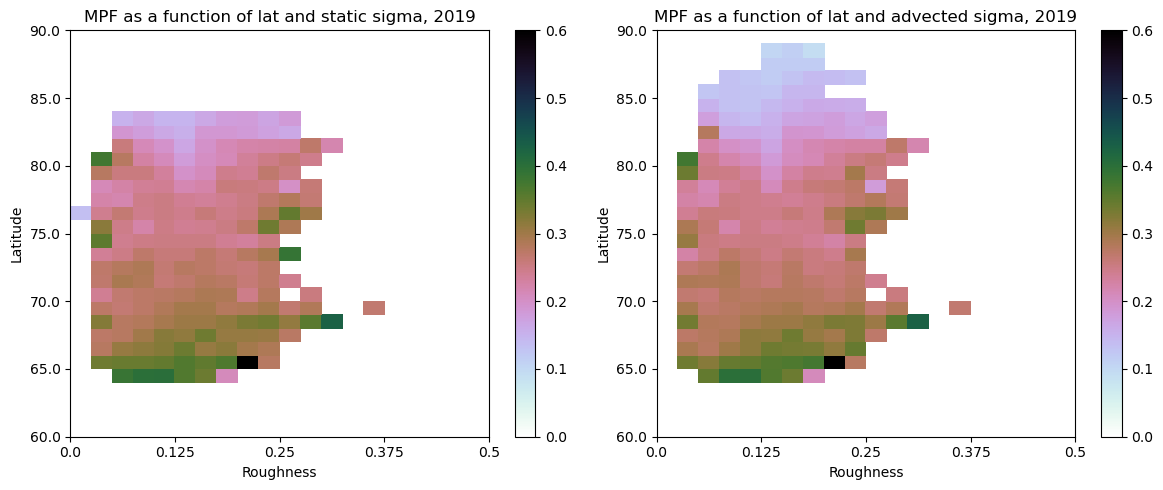

In [22]:
y_tick_positions = np.linspace(0, 30, 7) 
x_tick_positions = np.linspace(0, 20, 5)
y_tick_labels = np.linspace(60, 90, 7) 
x_tick_labels = np.linspace(0, 0.5, 5)

fig = plt.figure(figsize=(12,5))

masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_observed_mpf, april_MISR)
static_binned_stats = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_observed_mpf, mean_advected_MISR)
advected_binned_stats = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)


plt.subplot(121)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(static_binned_stats, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'MPF as a function of lat and static sigma, {YEAR}')


plt.subplot(122)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(advected_binned_stats, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'MPF as a function of lat and advected sigma, {YEAR}')


fig.tight_layout()
plt.show()

### Load array containing all mean summer SIRs calculated seperately:

In [8]:
all_sir = np.zeros((5, 1000000))
all_sir[0] = np.load('/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mean_summer_sir_2010.npy')
all_sir[1] = np.load('/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mean_summer_sir_2011.npy')
all_sir[2] = np.load('/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mean_summer_sir_2017.npy')
all_sir[3] = np.load('/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mean_summer_sir_2018.npy')
all_sir[4] = np.load('/home/htweedie/melt_ponds/data/forwarded_mpfs/testing/mean_summer_sir_2019.npy')
#all_sir[5] = np.zeros(1000000)


### Find annual binned averages and plot:

In [9]:
'''
#YEARS = [2010, 2011, 2017, 2018, 2019, 2020]
YEARS = [2010, 2011, 2017, 2018, 2019]
y_tick_positions = np.linspace(0, 30, 7) 
x_tick_positions = np.linspace(0, 20, 5)
y_tick_labels = np.linspace(60, 90, 7) 
x_tick_labels = np.linspace(0, 0.5, 5)

fig = plt.figure(figsize=(12,8))

annual_static_binned_stats = np.zeros((len(YEARS), 30, 20))
annual_advected_binned_stats = np.zeros((len(YEARS), 30, 20))
for i in range(len(YEARS)):
    year = YEARS[i]
    print(f'Processing {year}...')

    # retrieve April MISR 
    april_MISR = LOAD_MISR_H5(f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5')[::8,::8]
    print(f'Loaded MISR data')

    # retrieve advected MISR
    mean_advected_MISR = all_sir[i]

    # retrieve observed MPF 
    if YEAR >= 2017 and YEAR <= 2023:
        path = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}'
    elif YEAR >= 2002 and YEAR <= 2011:
        path = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}'
    summer_observed_mpf = np.zeros((4, 896*608))
    summer_observed_mpf[0,:] = np.load(f'{path}/mean_05_{YEAR}.npy').ravel()
    summer_observed_mpf[1,:] = np.load(f'{path}/mean_06_{YEAR}.npy').ravel()
    summer_observed_mpf[2,:] = np.load(f'{path}/mean_07_{YEAR}.npy').ravel()
    summer_observed_mpf[3,:] = np.load(f'{path}/mean_08_{YEAR}.npy').ravel()
    mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
    mean_observed_mpf = interpolate_to_MISR(x_mpf, y_mpf, mean_observed_mpf, x_MISR, y_MISR)

    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_observed_mpf.ravel(), april_MISR.ravel())
    static_binned_stats = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_observed_mpf.ravel(), mean_advected_MISR.ravel())
    advected_binned_stats = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

    plt.subplot(2,3,i+1)
    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(advected_binned_stats, cmap='cubehelix_r', vmin=0, vmax=0.6)
    plt.colorbar()
    plt.title(f'{year}')

    annual_static_binned_stats[i] = static_binned_stats
    annual_advected_binned_stats[i] = advected_binned_stats

fig.tight_layout()
plt.show()

np.save(f'/home/htweedie/melt_ponds/data/binned_stats/static_all_years_bins.npy', annual_static_binned_stats)
np.save(f'/home/htweedie/melt_ponds/data/binned_stats/advected_all_years_bins.npy', annual_advected_binned_stats)

# calculate mean bins:
mean_static_bins = np.zeros((30, 20))
mean_advected_bins = np.zeros((30, 20))
rows = 30
cols = 20
for i in range(rows):
    for j in range(cols):
        mean_static_bins[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])
        mean_advected_bins[i][j] = np.nanmean(annual_advected_binned_stats[:,i,j])

np.save(f'/home/htweedie/melt_ponds/data/binned_stats/static_mean_bins.npy', mean_static_bins)
np.save(f'/home/htweedie/melt_ponds/data/binned_stats/advected_mean_bins.npy', mean_advected_bins)
'''

'\n#YEARS = [2010, 2011, 2017, 2018, 2019, 2020]\nYEARS = [2010, 2011, 2017, 2018, 2019]\ny_tick_positions = np.linspace(0, 30, 7) \nx_tick_positions = np.linspace(0, 20, 5)\ny_tick_labels = np.linspace(60, 90, 7) \nx_tick_labels = np.linspace(0, 0.5, 5)\n\nfig = plt.figure(figsize=(12,8))\n\nannual_static_binned_stats = np.zeros((len(YEARS), 30, 20))\nannual_advected_binned_stats = np.zeros((len(YEARS), 30, 20))\nfor i in range(len(YEARS)):\n    year = YEARS[i]\n    print(f\'Processing {year}...\')\n\n    # retrieve April MISR \n    april_MISR = LOAD_MISR_H5(f\'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5\')[::8,::8]\n    print(f\'Loaded MISR data\')\n\n    # retrieve advected MISR\n    mean_advected_MISR = all_sir[i]\n\n    # retrieve observed MPF \n    if YEAR >= 2017 and YEAR <= 2023:\n        path = f\'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}\'\n    elif YEAR >= 2002 and YEAR <= 2011:\n        path = f\'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}\'\n    

### Calculate mean binned stats (mean of all years - climatology?) and plot:

In [10]:
mean_static_bins =  np.load('/home/htweedie/melt_ponds/data/binned_stats/static_mean_bins.npy')
mean_advected_bins =  np.load('/home/htweedie/melt_ponds/data/binned_stats/advected_mean_bins.npy')


/tmp/ipykernel_36160/2202999915.py:11: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_36160/2202999915.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


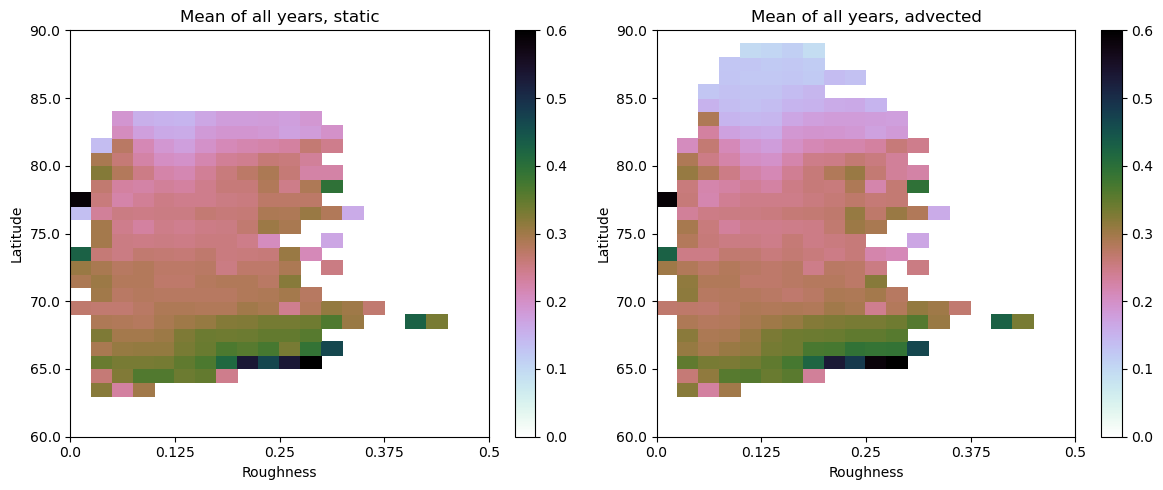

In [11]:
fig = plt.figure(figsize=(12,5))

plt.subplot(121)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(mean_static_bins, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'Mean of all years, static')


plt.subplot(122)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(mean_advected_bins, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'Mean of all years, advected')


fig.tight_layout()
plt.show()


### Calculate MPF predictions for pre-defined year and plot:

In [12]:
# define latitude and roughness bin edges
lat_edges = np.linspace(60, 90, num=31)  # 30 latitude bins
misr_edges = np.linspace(0, 0.5, num=20)  # 20 roughness bins

# get the bin indices and replace out-of-range indices with nans
lat_values = lat_MISR.ravel()
lat_indices = np.digitize(lat_values, lat_edges)
lat_indices = np.where((lat_indices == 0) | (lat_indices == len(lat_edges)), np.nan, lat_indices)

# List of values
misr_values_static = april_MISR.ravel()
misr_indices_static = np.digitize(misr_values_static, misr_edges)
misr_values_advected = mean_advected_MISR.ravel()
misr_indices_advected = np.digitize(misr_values_advected, misr_edges)

# # Replace out-of-range indices with nan
misr_indices_static = np.where((misr_indices_static == 0) | (misr_indices_static == len(misr_edges)), np.nan, misr_indices_static)
misr_indices_advected = np.where((misr_indices_advected == 0) | (misr_indices_advected == len(misr_edges)), np.nan, misr_indices_advected)



In [13]:
# for each position in 1000x1000 flattened array look at latitude and roughness ... then use collated data to predict an average for that point
predicted_mpf_static = np.zeros(1000000)
for i in range(1000000):
    current_misr_index = misr_indices_static[i]
    current_lat_index = lat_indices[i]
    if not (np.isnan(current_misr_index) or np.isnan(current_lat_index)):
        predicted_mpf_static[i] = mean_static_bins[current_lat_index.astype(int)][current_misr_index.astype(int)]
    else:
        predicted_mpf_static[i] = np.nan

predicted_mpf_advected = np.zeros(1000000)
for i in range(1000000):
    current_misr_index = misr_indices_advected[i]
    current_lat_index = lat_indices[i]
    if not (np.isnan(current_misr_index) or np.isnan(current_lat_index)):
        predicted_mpf_advected[i] = mean_advected_bins[current_lat_index.astype(int)][current_misr_index.astype(int)]
    else:
        predicted_mpf_advected[i] = np.nan

# We have created a faux mpf dataset for the specified year. 
# Data will be missing where data is missing in the roughness 


Static:

/tmp/ipykernel_36160/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_36160/2408197258.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_36160/2408197258.py:26: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


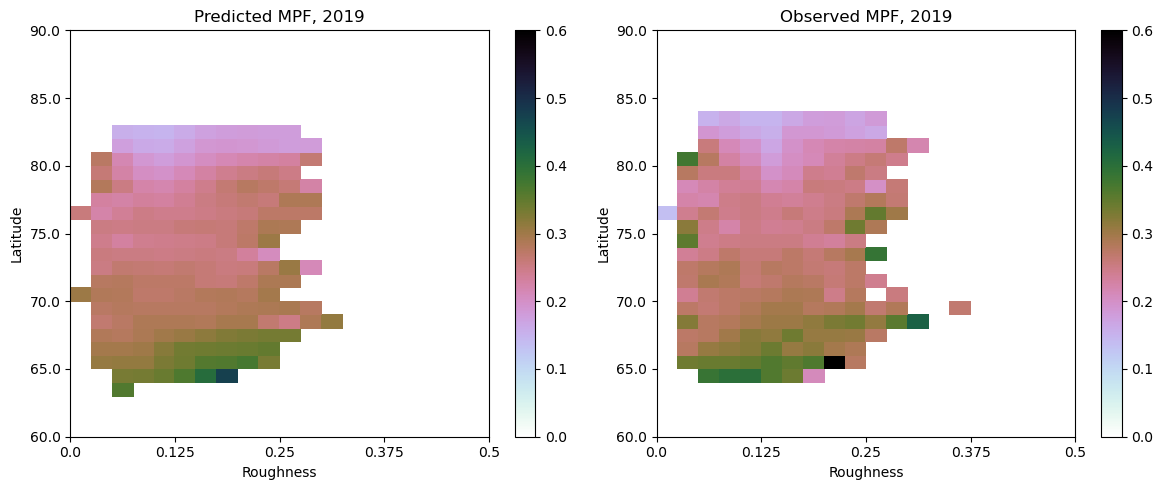

In [23]:
fig = plt.figure(figsize=(12,5))

masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(predicted_mpf_static, april_MISR.flatten())
predicted_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

plt.subplot(121)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(predicted_year_average, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'Predicted MPF, {YEAR}')


plt.subplot(122)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(static_binned_stats, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'Observed MPF, {YEAR}')


fig.tight_layout()
plt.show()

Advected:

/tmp/ipykernel_36160/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_36160/847942575.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_36160/847942575.py:26: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


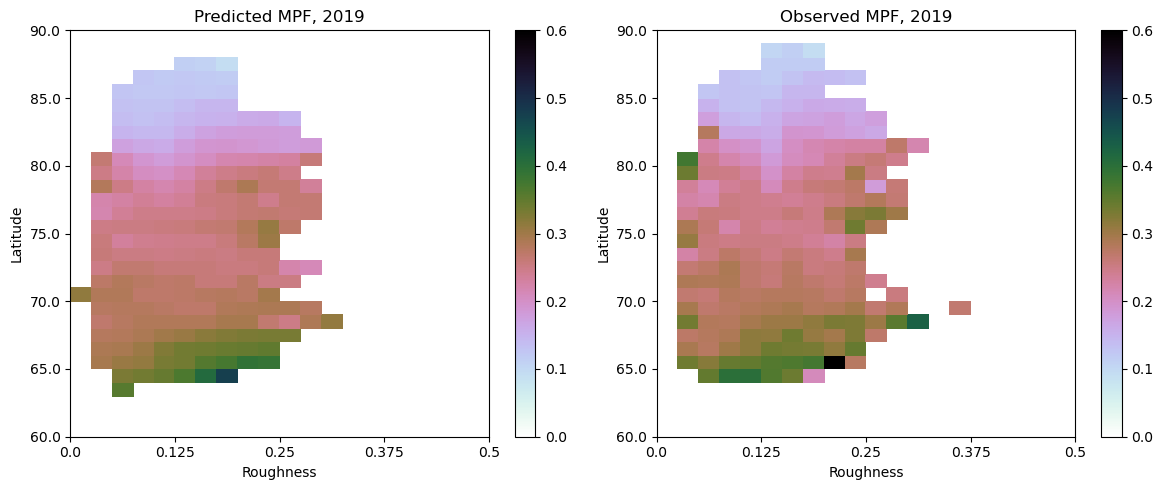

In [21]:
fig = plt.figure(figsize=(12,5))

masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(predicted_mpf_advected, mean_advected_MISR.flatten())
predicted_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

plt.subplot(121)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(predicted_year_average, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'Predicted MPF, {YEAR}')


plt.subplot(122)
plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
plt.yticks(y_tick_positions, y_tick_labels)

plt.ylabel("Latitude")
plt.xlabel("Roughness")

plt.pcolor(advected_binned_stats, cmap='cubehelix_r', vmin=0, vmax=0.6)
plt.colorbar()
plt.title(f'Observed MPF, {YEAR}')


fig.tight_layout()
plt.show()

### Plot predicted and observed MPF for all years with advected SIR:

Static:

MISR shape: (1000, 1000)


/tmp/ipykernel_86668/3278008442.py:34: RuntimeWarning: Mean of empty slice
  mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
/tmp/ipykernel_86668/3278008442.py:58: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/3278008442.py:93: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_86668/3278008442.py:108: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d)

MISR shape: (1000, 1000)


/tmp/ipykernel_86668/3278008442.py:34: RuntimeWarning: Mean of empty slice
  mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
/tmp/ipykernel_86668/3278008442.py:58: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/3278008442.py:93: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_86668/3278008442.py:108: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d)

MISR shape: (1000, 1000)


/tmp/ipykernel_86668/3278008442.py:34: RuntimeWarning: Mean of empty slice
  mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
/tmp/ipykernel_86668/3278008442.py:58: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/3278008442.py:93: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_86668/3278008442.py:108: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d)

MISR shape: (1000, 1000)


/tmp/ipykernel_86668/3278008442.py:34: RuntimeWarning: Mean of empty slice
  mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
/tmp/ipykernel_86668/3278008442.py:58: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/3278008442.py:93: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_86668/3278008442.py:108: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d)

MISR shape: (1000, 1000)


/tmp/ipykernel_86668/3278008442.py:34: RuntimeWarning: Mean of empty slice
  mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
/tmp/ipykernel_86668/3278008442.py:58: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/3278008442.py:93: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_86668/3278008442.py:108: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d)

MISR shape: (1000, 1000)


/tmp/ipykernel_86668/3278008442.py:34: RuntimeWarning: Mean of empty slice
  mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
/tmp/ipykernel_86668/3278008442.py:58: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_86668/3278008442.py:93: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_86668/3278008442.py:108: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d)

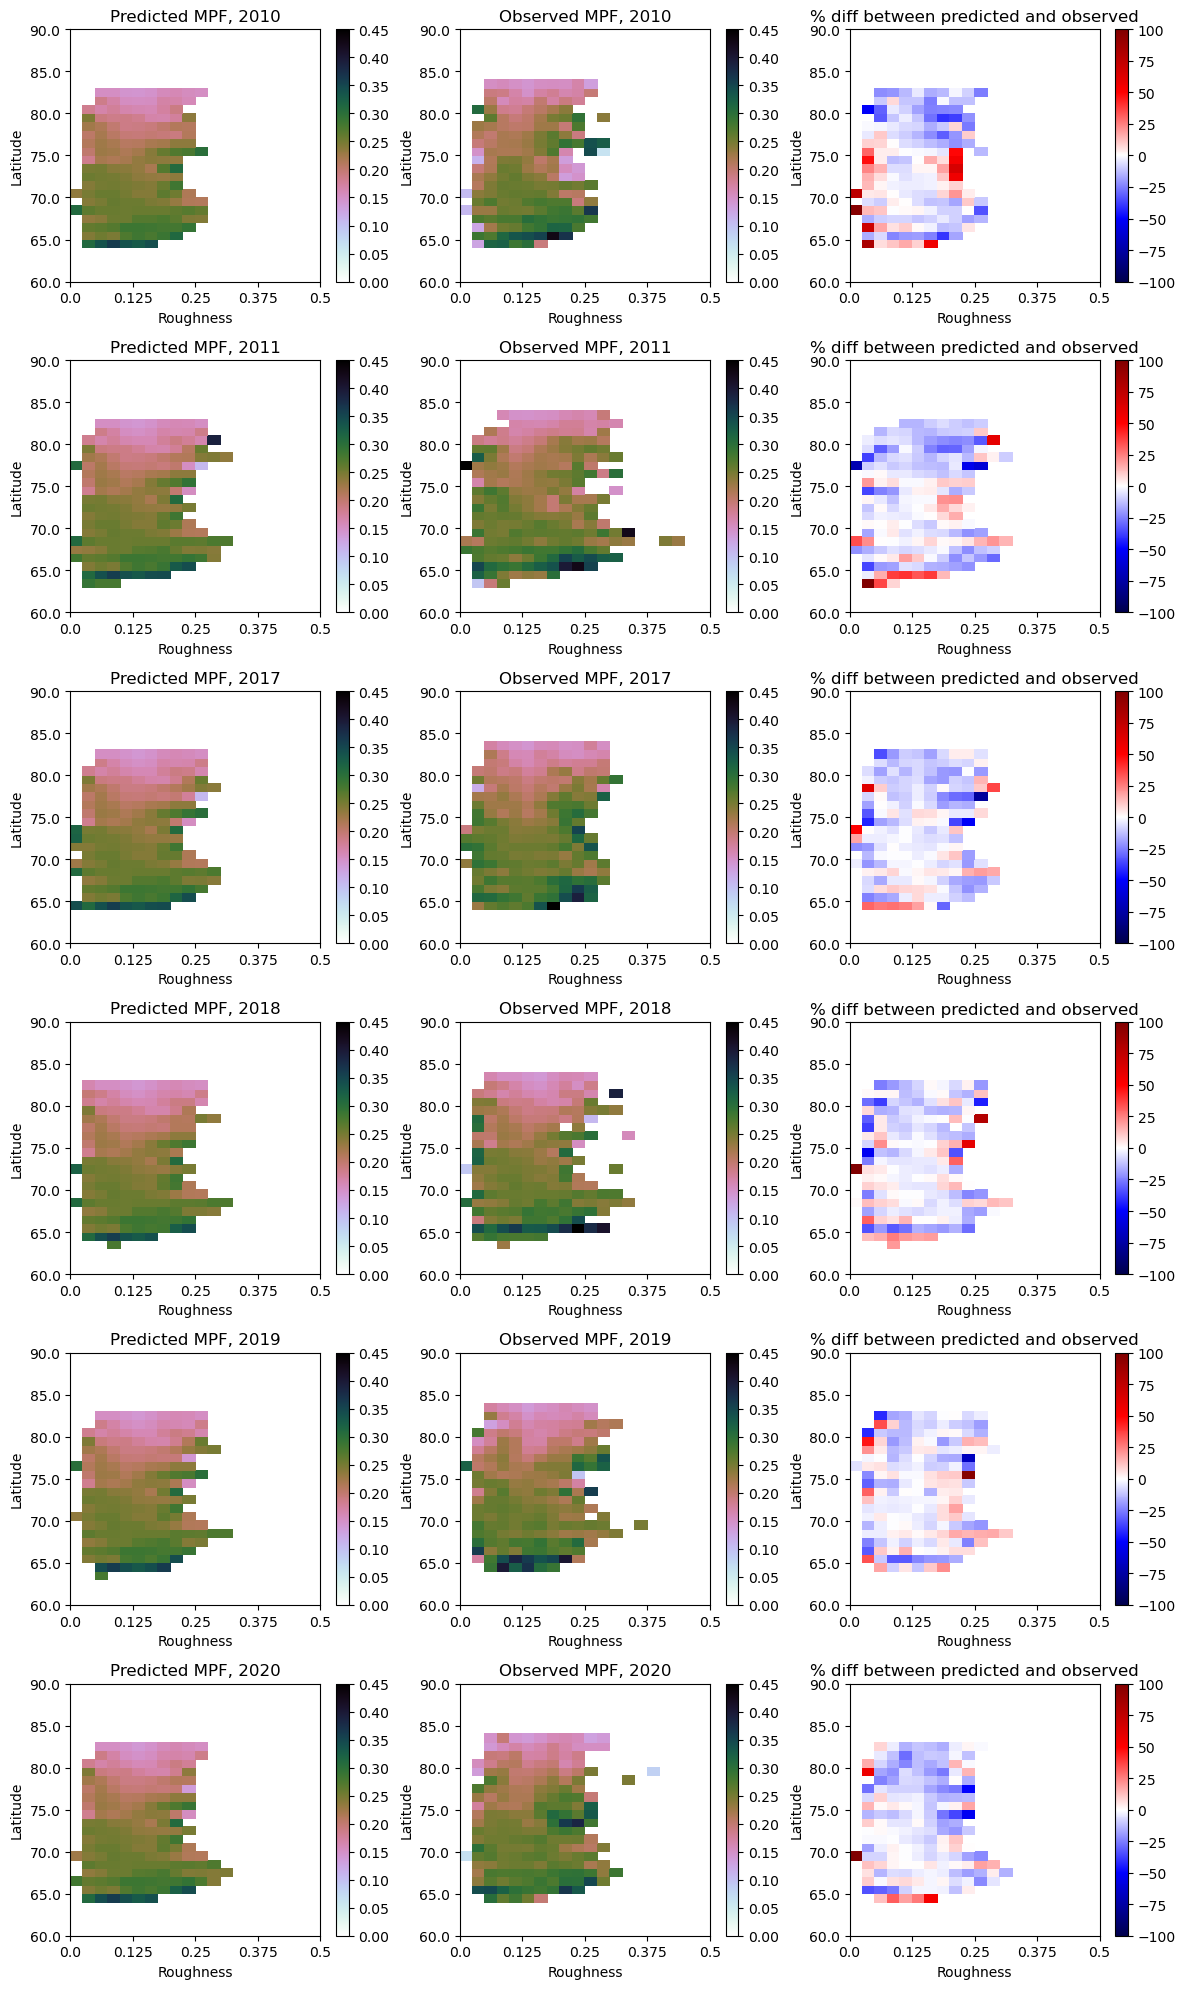

In [19]:
YEARS = [2010, 2011, 2017, 2018, 2019, 2020]

results_advected = np.zeros((6,3))
fig = plt.figure(figsize=(12,20))

y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
x_tick_positions = np.linspace(0, 20, 5)
y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
x_tick_labels = np.linspace(0, 0.5, 5)

for y in range(len(YEARS)):
    year = YEARS[y] 

    misr_path = f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5'
    lon_MISR, lat_MISR, x_MISR, y_MISR = MISR_COORDS(misr_path)

    april_MISR = LOAD_MISR_H5(misr_path)[::8,::8]
    lon_MISR = lon_MISR[::8,::8]
    lat_MISR = lat_MISR[::8,::8]
    x_MISR = x_MISR[::8,::8]
    y_MISR = y_MISR[::8,::8]
    print(f'MISR shape: {np.shape(april_MISR)}')

    # load observed MPF data
    if YEAR >= 2017 and YEAR <= 2023:
        path = f'/home/htweedie/melt_ponds/data/OLCI/olci/{YEAR}'
    elif YEAR >= 2002 and YEAR <= 2011:
        path = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{YEAR}'
    summer_observed_mpf = np.zeros((4, 896*608))
    summer_observed_mpf[0,:] = np.load(f'{path}/mean_05_{YEAR}.npy').ravel()
    summer_observed_mpf[1,:] = np.load(f'{path}/mean_06_{YEAR}.npy').ravel()
    summer_observed_mpf[2,:] = np.load(f'{path}/mean_07_{YEAR}.npy').ravel()
    summer_observed_mpf[3,:] = np.load(f'{path}/mean_08_{YEAR}.npy').ravel()
    mean_observed_mpf = np.nanmean(summer_observed_mpf, axis=0).reshape(896,608)
    mean_observed_mpf = interpolate_to_MISR(x_mpf, y_mpf, mean_observed_mpf, x_MISR, y_MISR).ravel()

    # define latitude and roughness bin edges
    lat_edges = np.linspace(60, 90, num=31)  # 30 latitude bins
    misr_edges = np.linspace(0, 0.5, num=20)  # 20 roughness bins

    # get the bin indices and replace out-of-range indices with nans
    lat_values = lat_MISR.ravel()
    lat_indices = np.digitize(lat_values, lat_edges)
    lat_indices = np.where((lat_indices == 0) | (lat_indices == len(lat_edges)), np.nan, lat_indices)

    # List of values
    misr_values = april_MISR.ravel()
    misr_indices = np.digitize(misr_values, misr_edges)

    # # Replace out-of-range indices with nan
    misr_indices = np.where((misr_indices == 0) | (misr_indices == len(misr_edges)), np.nan, misr_indices)

    total_mean = np.zeros((30, 20))
    rows = 30
    cols = 20
    for i in range(rows):
        for j in range(cols):
            total_mean[i][j] = np.nanmean(annual_static_binned_stats[:,i,j])

    predicted_mpf = np.zeros(1000000)
    for i in range(1000000):
        current_misr_index = misr_indices[i]
        current_lat_index = lat_indices[i]
        if not (np.isnan(current_misr_index) or np.isnan(current_lat_index)):
            predicted_mpf[i] = total_mean[current_lat_index.astype(int)][current_misr_index.astype(int)]
        else:
            predicted_mpf[i] = np.nan

    # mask data to keep only the points for which data are available for all three
    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_observed_mpf, april_MISR.flatten())
    observed_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(predicted_mpf, april_MISR.flatten())
    predicted_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)   

    results_advected[y,0] = np.nanmean(predicted_year_average)
    results_advected[y,1] = np.nanmean(observed_year_average)
    results_advected[y,2] = np.nanmean((np.square(predicted_year_average - observed_year_average)))


    # ----- predicted MPF ------

    plt.subplot(6,3,y*3+1)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(predicted_year_average, cmap='cubehelix_r', vmin=0, vmax=0.45)
    plt.title(f'Predicted MPF, {year}')
    plt.colorbar()


    # ----- observed MPF -----

    plt.subplot(6,3,y*3+2)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(observed_year_average, cmap='cubehelix_r', vmin=0, vmax=0.45)
    plt.title(f'Observed MPF, {year}')
    plt.colorbar()


    # ----- anomaly -----

    plt.subplot(6,3,y*3+3)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(perc_diff(predicted_year_average, observed_year_average), vmin=-100, vmax=100, cmap='seismic')
    plt.title(f'% diff between predicted and observed')
    plt.colorbar()


# Show the plot
fig.tight_layout()
plt.show()


In [18]:
results_advected

array([[0.23150169, 0.23209838, 0.00236876],
       [0.2333811 , 0.24183691, 0.00245462],
       [0.23281579, 0.24139003, 0.00137052],
       [0.23193841, 0.23806727, 0.00178508],
       [0.23122924, 0.23503246, 0.00133199],
       [0.2307264 , 0.23733856, 0.0014182 ]])

MISR shape: (1000, 1000)


/tmp/ipykernel_208052/2135749632.py:39: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/2135749632.py:73: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(yearly_averages[:,i,j])


Overall mean shape: (30, 20)
Processing 2010...
Loaded MISR data


/tmp/ipykernel_208052/2135749632.py:103: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/2135749632.py:137: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_208052/2135749632.py:152: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavio

MISR shape: (1000, 1000)


/tmp/ipykernel_208052/2135749632.py:39: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/2135749632.py:73: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(yearly_averages[:,i,j])


Overall mean shape: (30, 20)
Processing 2011...
Loaded MISR data


/tmp/ipykernel_208052/2135749632.py:103: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/2135749632.py:137: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_208052/2135749632.py:152: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavio

MISR shape: (1000, 1000)


/tmp/ipykernel_208052/2135749632.py:39: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/2135749632.py:73: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(yearly_averages[:,i,j])


Overall mean shape: (30, 20)
Processing 2017...
Loaded MISR data


/tmp/ipykernel_208052/2135749632.py:103: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/2135749632.py:137: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_208052/2135749632.py:152: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavio

MISR shape: (1000, 1000)


/tmp/ipykernel_208052/2135749632.py:39: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/2135749632.py:73: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(yearly_averages[:,i,j])


Overall mean shape: (30, 20)
Processing 2018...
Loaded MISR data


/tmp/ipykernel_208052/2135749632.py:103: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/2135749632.py:137: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_208052/2135749632.py:152: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavio

MISR shape: (1000, 1000)


/tmp/ipykernel_208052/2135749632.py:39: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/2135749632.py:73: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(yearly_averages[:,i,j])


Overall mean shape: (30, 20)
Processing 2019...
Loaded MISR data


/tmp/ipykernel_208052/2135749632.py:103: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/2135749632.py:137: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_208052/2135749632.py:152: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavio

MISR shape: (1000, 1000)


/tmp/ipykernel_208052/2135749632.py:39: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/2135749632.py:73: RuntimeWarning: Mean of empty slice
  total_mean[i][j] = np.nanmean(yearly_averages[:,i,j])


Overall mean shape: (30, 20)
Processing 2020...
Loaded MISR data


/tmp/ipykernel_208052/2135749632.py:103: RuntimeWarning: Mean of empty slice
  mean_mpf = np.nanmean(mpf, axis=0)
/tmp/ipykernel_208052/1280991242.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = pyproj.transform(proj_WGS84, proj_EASE2N, lon, lat)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/1280991242.py:61: RuntimeWarning: Mean of empty slice
  return np.nanmean(x)
/tmp/ipykernel_208052/2135749632.py:137: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_208052/2135749632.py:152: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavio

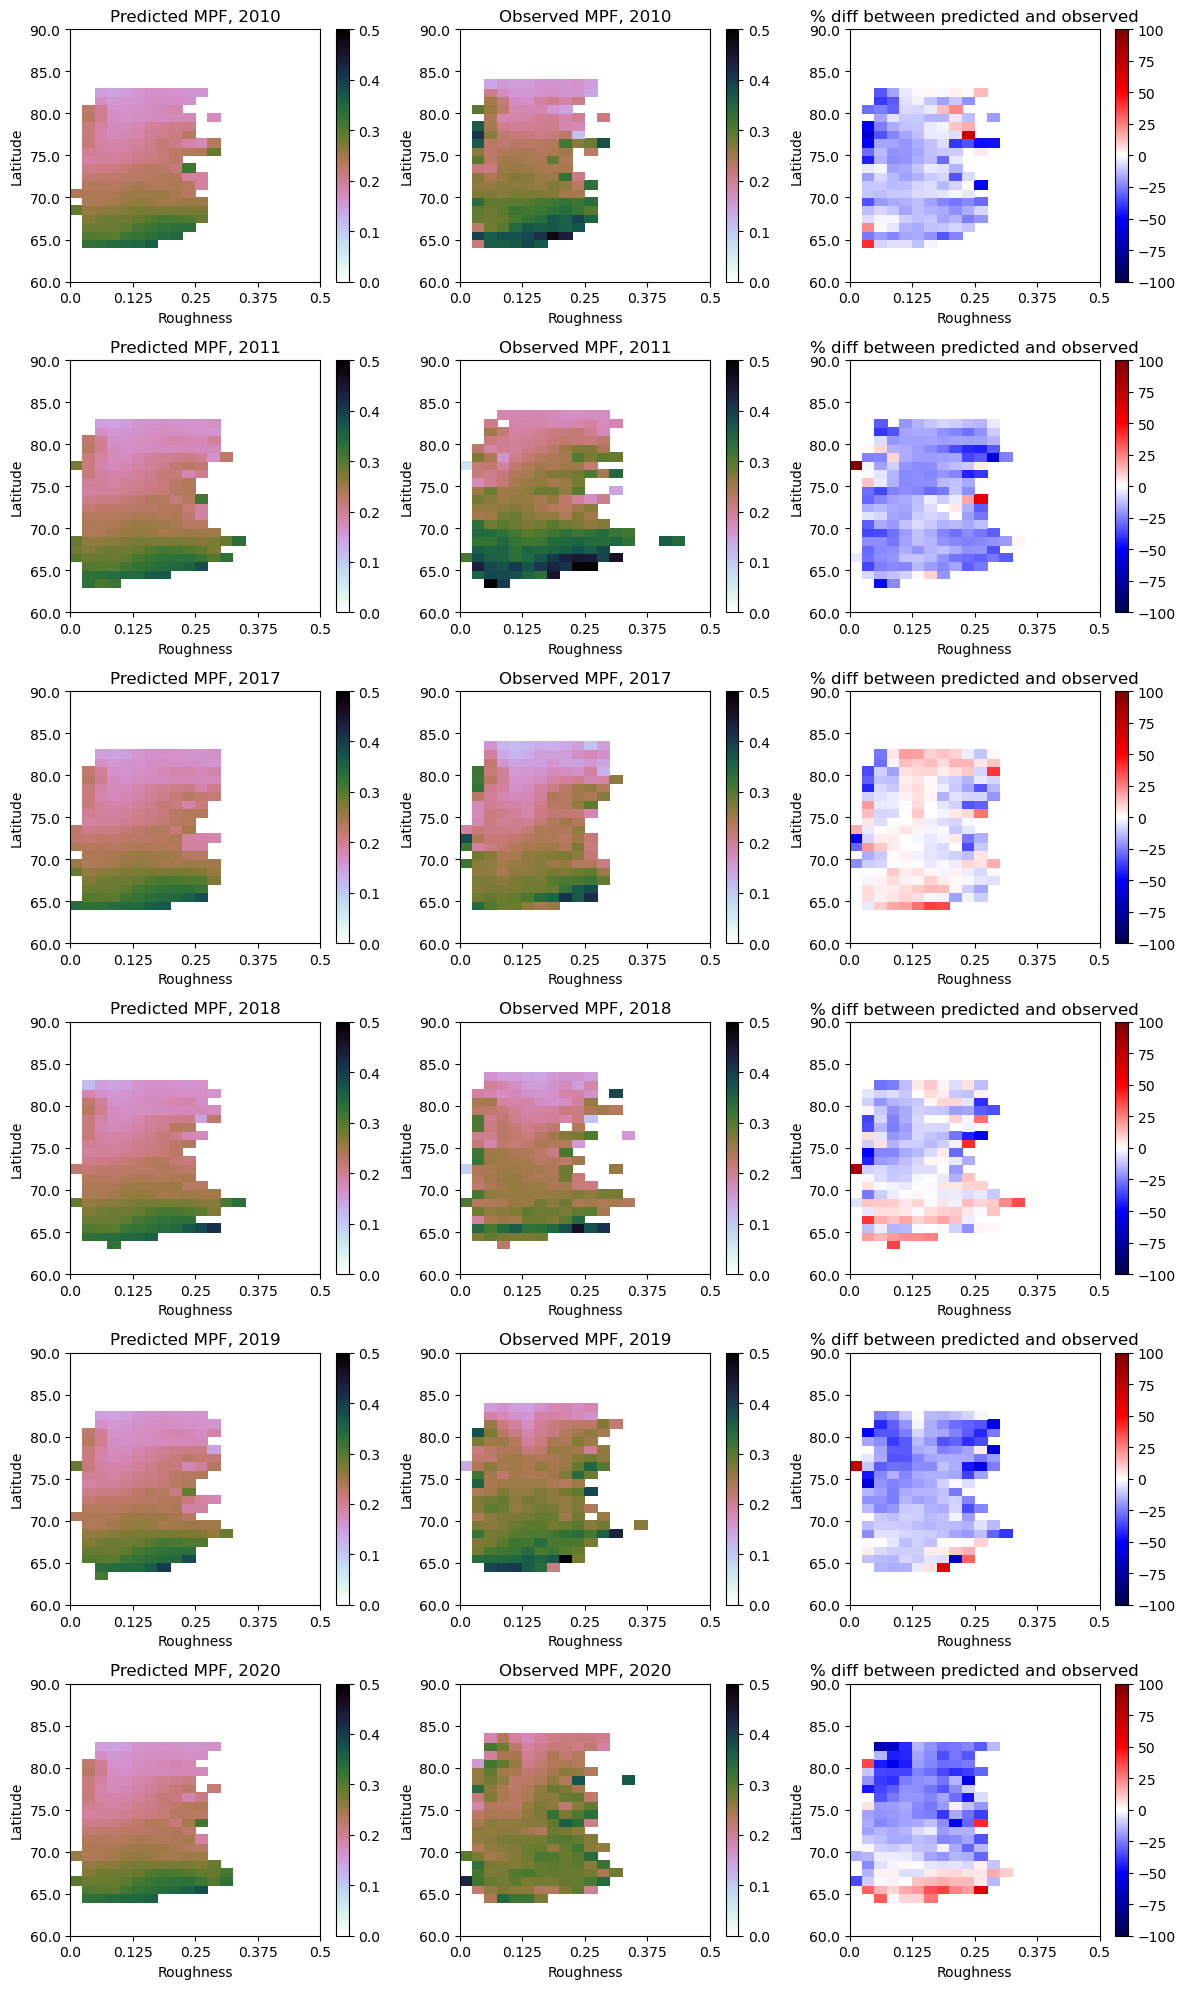

In [21]:
YEARS = [2010, 2011, 2017, 2018, 2019, 2020]

results_static = np.zeros((6,3))
fig = plt.figure(figsize=(12,20))

y_tick_positions = np.linspace(0, 30, 7) # Takes default tick markings and changes them to the range of the data
x_tick_positions = np.linspace(0, 20, 5)
y_tick_labels = np.linspace(60, 90, 7) # Genate latitude values for 60 to 90
x_tick_labels = np.linspace(0, 0.5, 5)

for y in range(len(YEARS)):
    year = YEARS[y] 

    misr_path = f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5'
    lon_MISR, lat_MISR, x_MISR, y_MISR = MISR_COORDS(misr_path)

    MISR = LOAD_MISR_H5(misr_path)[::8,::8]
    lon_MISR = lon_MISR[::8,::8]
    lat_MISR = lat_MISR[::8,::8]
    x_MISR = x_MISR[::8,::8]
    y_MISR = y_MISR[::8,::8]
    print(f'MISR shape: {np.shape(MISR)}')

    if year >= 2017 and year <= 2023:
        path = f'/home/htweedie/melt_ponds/data/OLCI/olci/{year}'
    elif year >= 2002 and year <= 2011:
        path = f'/home/htweedie/melt_ponds/data/MERIS/mecosi/{year}'
        
    may_mpf = np.load(f'{path}/mean_05_{year}.npy').ravel()
    jun_mpf = np.load(f'{path}/mean_06_{year}.npy').ravel()
    jul_mpf = np.load(f'{path}/mean_07_{year}.npy').ravel()
    aug_mpf = np.load(f'{path}/mean_08_{year}.npy').ravel()

    mpf = np.zeros([4,len(may_mpf)])
    mpf[0,:] = may_mpf
    mpf[1,:] = jun_mpf
    mpf[2,:] = jul_mpf
    mpf[3,:] = aug_mpf
    mean_mpf = np.nanmean(mpf, axis=0)

    # retrieve MPF coordinates
    coord_fn = '/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5'
    coords = h5.File(coord_fn, 'r')
    mpf_lon =  np.array(coords['Longitudes'])
    mpf_lat = np.array(coords['Latitudes'])
    x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)
    mean_mpf_reshaped = interpolate_to_MISR(x_mpf, y_mpf, mean_mpf, x_MISR, y_MISR)

    # define latitude and roughness bin edges
    lat_edges = np.linspace(60, 90, num=31)  # 30 latitude bins
    misr_edges = np.linspace(0, 0.5, num=20)  # 20 roughness bins

    # get the bin indices and replace out-of-range indices with nans
    lat_values = lat_MISR.ravel()
    lat_indices = np.digitize(lat_values, lat_edges)
    lat_indices = np.where((lat_indices == 0) | (lat_indices == len(lat_edges)), np.nan, lat_indices)

    # List of values
    misr_values = MISR.ravel()
    misr_indices = np.digitize(misr_values, misr_edges)

    # # Replace out-of-range indices with nan
    misr_indices = np.where((misr_indices == 0) | (misr_indices == len(misr_edges)), np.nan, misr_indices)


    total_mean = np.zeros((30, 20))

    rows = 30
    cols = 20

    for i in range(rows):
        for j in range(cols):
            total_mean[i][j] = np.nanmean(yearly_averages[:,i,j])

    print(f'Overall mean shape: {total_mean.shape}')


    predicted_mpf = np.zeros(1000000)
    for i in range(1000000):
        current_misr_index = misr_indices[i]
        current_lat_index = lat_indices[i]
        if not (np.isnan(current_misr_index) or np.isnan(current_lat_index)):
            predicted_mpf[i] = total_mean[current_lat_index.astype(int)][current_misr_index.astype(int)]
        else:
            predicted_mpf[i] = np.nan


    print(f'Processing {year}...')
    MISR = LOAD_MISR_H5(f'/home/ssureen/MISR_data_monthly/April {year} Roughness.h5')[::8,::8]
    print(f'Loaded MISR data')

    # load, subset and find mean of mpf data
    may_mpf = np.load(f'{path}/mean_05_{year}.npy').ravel()
    jun_mpf = np.load(f'{path}/mean_06_{year}.npy').ravel()
    jul_mpf = np.load(f'{path}/mean_07_{year}.npy').ravel()
    aug_mpf = np.load(f'{path}/mean_08_{year}.npy').ravel()

    mpf = np.zeros([4,len(may_mpf)])
    mpf[0,:] = may_mpf
    mpf[1,:] = jun_mpf
    mpf[2,:] = jul_mpf
    mpf[3,:] = aug_mpf
    mean_mpf = np.nanmean(mpf, axis=0)

    # retrieve MPF coordinates
    coord_fn = '/home/htweedie/melt_ponds/data/OLCI/olci/LongitudeLatitudeGrid-n12500-Arctic.h5'
    coords = h5.File(coord_fn, 'r')
    mpf_lon =  np.array(coords['Longitudes'])
    mpf_lat = np.array(coords['Latitudes'])
    x_mpf, y_mpf = WGS84toEASE2N(mpf_lon, mpf_lat)
    mean_mpf_reshaped = interpolate_to_MISR(x_mpf, y_mpf, mean_mpf, x_MISR, y_MISR)

    # mask data to keep only the points for which data are available for all three
    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(mean_mpf_reshaped, MISR)
    observed_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(predicted_mpf, MISR.flatten())
    predicted_year_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)   

    results_static[y,0] = np.nanmean(predicted_year_average)
    results_static[y,1] = np.nanmean(observed_year_average)
    results_static[y,2] = np.nanmean((np.square(predicted_year_average - observed_year_average)))


    # ----- predicted MPF ------

    plt.subplot(6,3,y*3+1)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(predicted_year_average, cmap='cubehelix_r', vmin=0, vmax=0.5)
    plt.title(f'Predicted MPF, {year}')
    plt.colorbar()


    # ----- observed MPF -----

    plt.subplot(6,3,y*3+2)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(observed_year_average, cmap='cubehelix_r', vmin=0, vmax=0.5)
    plt.title(f'Observed MPF, {year}')
    plt.colorbar()


    # ----- anomaly -----

    plt.subplot(6,3,y*3+3)

    plt.xticks(x_tick_positions, x_tick_labels) # Relabel ticks
    plt.yticks(y_tick_positions, y_tick_labels)

    plt.ylabel("Latitude")
    plt.xlabel("Roughness")

    plt.pcolor(perc_diff(predicted_year_average, observed_year_average), vmin=-100, vmax=100, cmap='seismic')
    plt.title(f'% diff between predicted and observed')
    plt.colorbar()


# Show the plot
fig.tight_layout()
plt.show()


In [22]:
print(f'Advected results:\n{results_advected}')
print(f'Static results:\n{results_static}')
print(f'Static-advected:\n{results_static-results_advected}')

Advected results:
[[0.23070379 0.25932949 0.00318873]
 [0.2350005  0.27426795 0.00518756]
 [0.23103375 0.20669961 0.00152063]
 [0.23213885 0.21617956 0.00159474]
 [0.23007781 0.24305621 0.00228933]
 [0.23420529 0.23795667 0.00254704]]
Static results:
[[0.23070379 0.25977919 0.00279586]
 [0.2350005  0.27695204 0.00383309]
 [0.23103375 0.22937978 0.00105345]
 [0.23213885 0.23806727 0.00156782]
 [0.23007781 0.26572358 0.00366597]
 [0.23420529 0.2635408  0.00360416]]
Static-advected:
[[ 0.00000000e+00  4.49691995e-04 -3.92870206e-04]
 [ 0.00000000e+00  2.68409026e-03 -1.35446427e-03]
 [ 0.00000000e+00  2.26801719e-02 -4.67188999e-04]
 [ 0.00000000e+00  2.18877171e-02 -2.69234199e-05]
 [ 0.00000000e+00  2.26673717e-02  1.37664554e-03]
 [ 0.00000000e+00  2.55841223e-02  1.05711741e-03]]


In [24]:
print(f'Predicted mean: {np.nanmean(predicted_year_average)}')
print(f'Observed mean: {np.nanmean(observed_year_average)}')

mse = np.nanmean((np.square(predicted_year_average - observed_year_average)))
print(f'Mean squared error: {mse}')

var = np.nanvar(predicted_year_average)
print(f'Variance: {var}')
R_sq = 1 - (mse/var)
print(f'R-squared: {R_sq}')

Predicted mean: 0.23420529199133114
Observed mean: 0.2635407954814758
Mean squared error: 0.0036041621107827724
Variance: 0.0028543448388998697
R-squared: -0.26269330238735256


/tmp/ipykernel_208052/1280991242.py:125: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


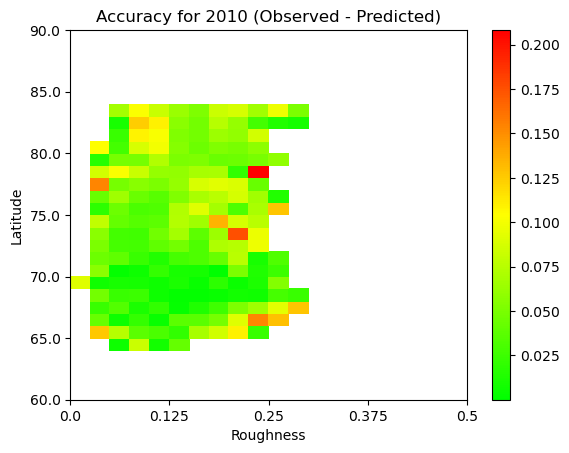

In [25]:
accuracy = np.abs(yearly_averages[2,:,:]-current_year_average)

# Create a custom colormap that goes from green to yellow to red
colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Green, Yellow, Red
n_bins = 200  # Number of bins in the colormap
cmap_name = 'green_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plot_binned_accuracy(accuracy, custom_cmap, f'Accuracy for {YEAR} (Observed - Predicted)')

### Calculating Accuracy for Last 3 Years

In [26]:
new_years = [*range(0,20)]
# exclude_year = 5
# years_to_be_averaged = new_years.remove(exclude_year)
# print(years_to_be_averaged)

In [27]:
# SAME FOR ALL FILES

# Define the bin edges latitude
lat_edges = np.linspace(60, 90, num=31)  # 30 bins latitude

# List of values
values = lat_MISR.ravel()

# Use digitize to get the bin indices
lat_indices = np.digitize(values, lat_edges)

# Replace out-of-range indices with nan
lat_indices = np.where((lat_indices == 0) | (lat_indices == len(lat_edges)), np.nan, lat_indices)

In [28]:
def predict_mpf(misr_path, total_average_with_exclusion):
    global current_MISR
    current_MISR = LOAD_MISR_H5(misr_path)

    # Create empty array with 0s
    predicted_mpf = np.zeros((64000000))

    # Define the bin edges roughness
    rough_edges = np.linspace(0, 0.5, num=20)  # 20 bins roughness

    # List of values
    values = current_MISR.ravel()

    # Use digitize to get the bin indices
    rough_indices = np.digitize(values, rough_edges)

    # # Replace out-of-range indices with nan
    rough_indices = np.where((rough_indices == 0) | (rough_indices == len(rough_edges)), np.nan, rough_indices)

    for i in range(64000000):
        current_rough_index = rough_indices[i]
        current_lat_index = lat_indices[i]
        if not (np.isnan(current_rough_index) or np.isnan(current_lat_index)):
            predicted_mpf[i] = total_average_with_exclusion[current_lat_index.astype(int)][current_rough_index.astype(int)]
        else:
            predicted_mpf[i] = np.nan

    return predicted_mpf


    

In [29]:
rows = 30
cols = 20

year_index = 3 

relative_accuracy_shape = (year_index, 30, 20) # 3D array stores averages for all years (years, lat bins, rough bins)
relative_accuracy_scores = np.zeros(relative_accuracy_shape) # setting up array with 0s

for index_to_exclude in range(0, year_index):

    yearly_averages_with_exclusion = np.concatenate((yearly_averages_loaded[:(-index_to_exclude-1),:,:], yearly_averages_loaded[(-index_to_exclude):,:,:]), axis=0)

    current_real_average = yearly_averages_loaded[(-index_to_exclude-1),:,:]

    current_misr_path = misr_path_list[(-index_to_exclude-1)]
    current_mpf_path = mpf_path_list[(-index_to_exclude-1)]

    total_average_with_exclusion = np.zeros((30, 20))

    for j in range(rows):
        for k in range(cols):
            total_average_with_exclusion[j][k] = np.nanmean(yearly_averages_with_exclusion[:,j,k])

    predicted_mpf = predict_mpf(current_misr_path, total_average_with_exclusion) # predicts raw mpf array

    masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR = MASK_MPF_MISR(predicted_mpf, current_MISR.flatten())
    current_predicted_average = calculate_binned_averages(masked_MPF_MISRGRID, masked_MISR, masked_lat_MISR)

    plot_binned_stats(current_predicted_average)

    plot_binned_stats(current_real_average)
    
    accuracy = current_predicted_average-current_real_average
    relative_accuracy= np.abs((accuracy/current_real_average))
    relative_accuracy_scores[index_to_exclude] = relative_accuracy
    plot_binned_accuracy(relative_accuracy, custom_cmap)

    

    

    

NameError: name 'yearly_averages_loaded' is not defined

In [ ]:
print(relative_accuracy_scores)

[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]


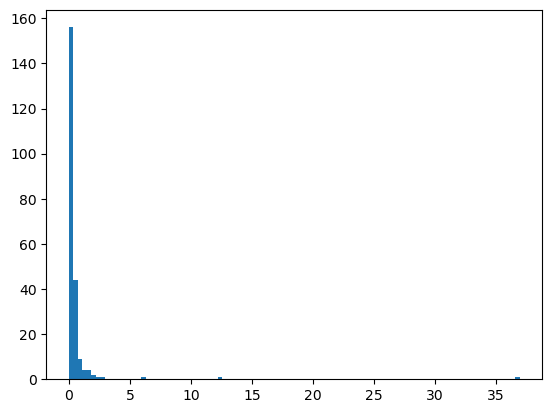

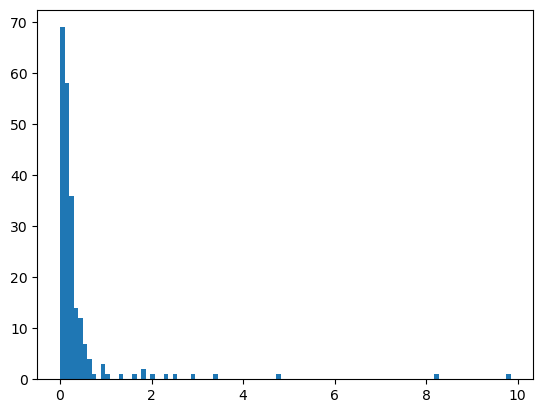

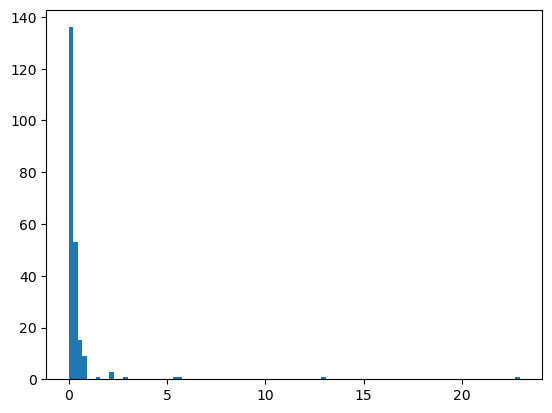

In [ ]:
for i in range(0,3):
    plt.hist(relative_accuracy_scores[i].flatten(), bins = 100)
    plt.show()

[0.23760348944697013, 0.2718342157794257, 0.2157304888935049, 0.18411598751816502, 0.18639225034516008, 0.2128970231216964, 0.2408604883630756, 0.29820895938820846, 0.3326675265181414, 0.3471519768640023, 0.30830332676248207, 0.23435597850471956, 0.3282734813982104, 0.2687940891979031, 0.23396454047627693, nan, nan, nan, nan, nan]


/tmp/ipykernel_309302/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


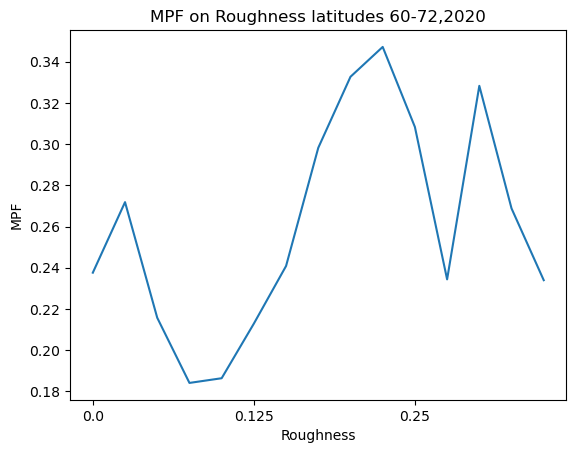

[0.37346073965335164, 0.21837493343909384, 0.3114471166543028, 0.29057094221326835, 0.2561388243607954, 0.2451000016996322, 0.24542472431916929, 0.2480520070577093, 0.2871400867718607, 0.2339252053836526, 0.23342245028256917, 0.16907695320466284, 0.24024571452186785, 0.278122773881039, 0.16318648606702907, nan, nan, nan, nan, nan]


/tmp/ipykernel_309302/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


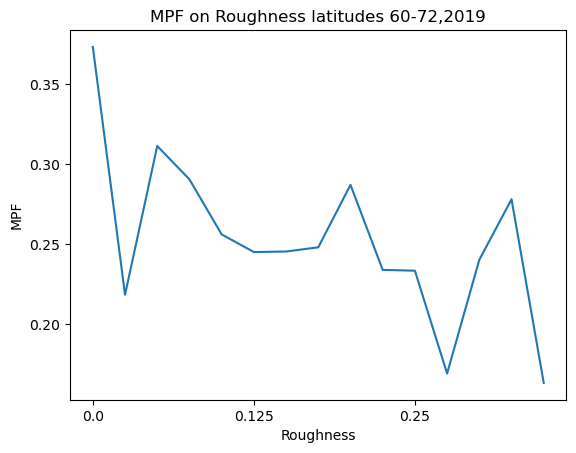

/tmp/ipykernel_309302/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


[0.14577789106977312, 0.3335486912308568, 0.3102940224937833, 0.3206297985514445, 0.34726376493971706, 0.3466535356850358, 0.32226764660136037, 0.30752980252036877, 0.29134531736466424, 0.2360103743890385, 0.2058731499371098, 0.20991850896543948, 0.14181897244755942, nan, nan, nan, nan, nan, nan, nan]


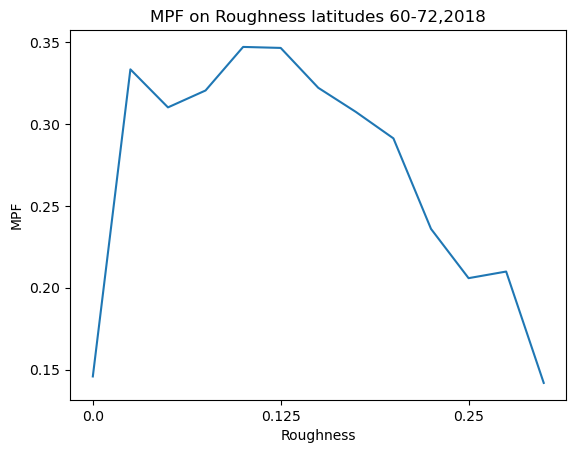

/tmp/ipykernel_309302/4019258049.py:7: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))


[0.5221407432699088, 0.2256109373410597, 0.22983661587470106, 0.2595418523461592, 0.2521908866889989, 0.2677073825074691, 0.2677779350693366, 0.2490018660948051, 0.23866344410682783, 0.2623903692334329, 0.2752653525336748, 0.29686490724083886, 0.3636489615405022, 0.40239907416688786, 0.47304023957596375, 0.2524982173462969, 0.4751962477759563, nan, nan, nan]


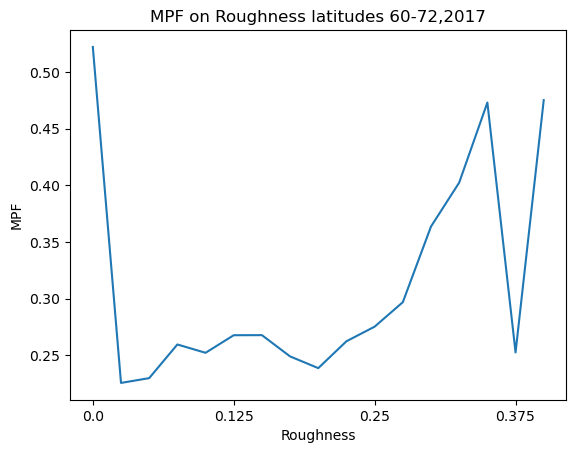

In [ ]:
for year in range(0,4):

    real_year = 2020-year

    mpf_slice = []
    for col_index in range(0,20):
        mpf_slice.append(np.nanmean(yearly_averages_loaded[(-year-1),0:12,col_index]))
    print(mpf_slice)
    x_tick_positions = np.linspace(0, 20, 5)
    x_tick_labels = np.linspace(0, 0.5, 5)
    plt.xticks(x_tick_positions, x_tick_labels)
    plt.xlabel('Roughness')
    plt.ylabel('MPF')
    plt.title('MPF on Roughness latitudes 60-72,'+str(real_year))
    plt.plot(mpf_slice)
    plt.show()
    


/tmp/ipykernel_309302/1860741435.py:3: RuntimeWarning: Mean of empty slice
  mpf_slice.append(np.nanmean(yearly_averages_loaded[-1,0:12,col_index]))


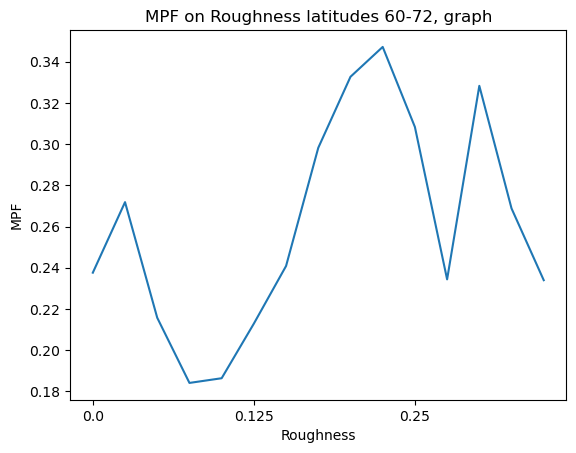

In [ ]:

mpf_slice = []
for col_index in range(0,20):
    mpf_slice.append(np.nanmean(yearly_averages_loaded[-1,0:12,col_index]))

x_tick_positions = np.linspace(0, 20, 5)
x_tick_labels = np.linspace(0, 0.5, 5)
plt.xticks(x_tick_positions, x_tick_labels)
plt.xlabel('Roughness')
plt.ylabel('MPF')
plt.title('MPF on Roughness latitudes 60-72, graph')
plt.plot(mpf_slice)
plt.show()
    
